In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras import optimizers
import numpy as np
import sys
from PIL import Image
import pickle
from io import BytesIO
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import bz2

Using TensorFlow backend.


In [3]:
def load(fname):
    fin = bz2.BZ2File(fname, 'rb')
    try:
        pkl = fin.read()
    finally:
        fin.close()
    return pickle.loads(pkl)

In [4]:
with open('insta_images_small.pkl', 'rb') as f:
    insta_images = load(f)
with open('twitter_images_small.pkl', 'rb') as f:
    twitter_images = load(f)
with open('fb_images_small.pkl', 'rb') as f:
    fb_images = load(f)

In [5]:
images = np.array(insta_images + twitter_images + fb_images)

In [6]:
labels = np.zeros(len(insta_images), dtype=np.int32)
labels = np.append(labels, np.ones(len(twitter_images), dtype=np.int32))
labels = np.append(labels, np.ones(len(fb_images), dtype=np.int32)+1)
labels = np.eye(3)[labels]

In [7]:
images, labels = shuffle(images, labels, random_state=42)
train_X, valid_X, train_y, valid_y = train_test_split(images, labels, test_size=0.1, random_state=42)

In [8]:
input_tensor = Input(shape=(100, 100, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# FC層を構築
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.2))
top_model.add(Dense(3, activation='softmax'))

# VGG16とFCを接続
model = Model(input=vgg16.input, output=top_model(vgg16.output))

# 最後のconv層の直前までの層をfreeze
for layer in model.layers[:15]:
    layer.trainable = False

# Fine-tuningのときはSGDの方がよい
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [9]:
# 学習の実施
history = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(valid_X, valid_y), shuffle=True)

# 重みの保存
model.save_weights('./out/vgg16_transferlearning_weights2.h5')

Train on 8068 samples, validate on 897 samples
Epoch 1/10
8068/8068 [==============================] - 375s 47ms/step - loss: 1.5867 - acc: 0.5059 - val_loss: 0.9302 - val_acc: 0.5853
Epoch 2/10
8068/8068 [==============================] - 349s 43ms/step - loss: 0.8762 - acc: 0.5957 - val_loss: 0.9012 - val_acc: 0.5808
Epoch 3/10
8068/8068 [==============================] - 347s 43ms/step - loss: 0.7914 - acc: 0.6475 - val_loss: 0.8245 - val_acc: 0.6332
Epoch 4/10
8068/8068 [==============================] - 349s 43ms/step - loss: 0.7182 - acc: 0.6857 - val_loss: 0.8541 - val_acc: 0.6355
Epoch 5/10
8068/8068 [==============================] - 349s 43ms/step - loss: 0.6547 - acc: 0.7162 - val_loss: 0.7721 - val_acc: 0.6611
Epoch 6/10
8068/8068 [==============================] - 354s 44ms/step - loss: 0.5895 - acc: 0.7496 - val_loss: 0.8273 - val_acc: 0.6711
Epoch 7/10
8068/8068 [==============================] - 359s 45ms/step - loss: 0.5399 - acc: 0.7722 - val_loss: 0.7767 - val_acc: 0

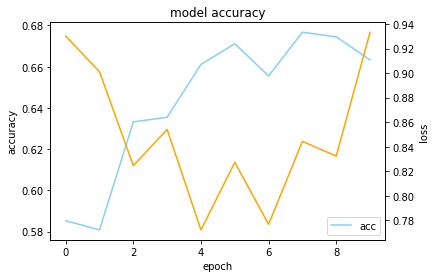

In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
    # print(history.history.keys())
    fig, ax1 = plt.subplots()
    ax1.plot(history.history['val_acc'], color='lightskyblue')
    ax2 = ax1.twinx()
    ax2.plot(history.history['val_loss'], color='orange')
    plt.title('model accuracy')
    ax1.legend(['acc', 'loss'], loc='lower right')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax2.set_ylabel('loss')

    plt.savefig('accuracy_loss2.png')
    plt.show()

# 学習履歴をプロット
plot_history(history)

In [ ]:
with open('non_dropout2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

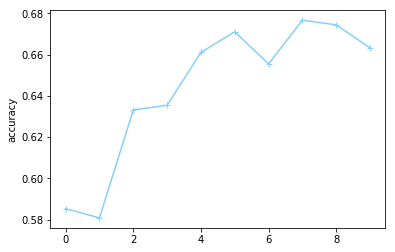

In [18]:
fig, axis1 = plt.subplots()

axis1.set_ylabel('accuracy')

axis1.plot(history.history['val_acc'], marker='+', label='accuracy', color='lightskyblue')

plt.savefig('accuracy2.png')

plt.show()

In [19]:
results = model.predict(images)

In [20]:
def predict(i):
    result = results[i:i+1]
    if labels[i][0] == 1:
        print('Instagram')
    elif labels[i][1] == 1:
        print('Twitter')
    elif labels[i][2] == 1:
        print('Facebook')
    print('Instagram: {}'.format(result[0][0]))
    print('Twitter  : {}'.format(result[0][1]))
    print('Facebook : {}'.format(result[0][2]))

In [21]:
for i in range(10):
    print('==={}==='.format(i))
    predict(i)
    print('========')

===0===
Facebook
Instagram: 0.000837924366351217
Twitter  : 0.07415575534105301
Facebook : 0.9250063896179199
===1===
Facebook
Instagram: 0.00469555240124464
Twitter  : 0.03660023957490921
Facebook : 0.9587041735649109
===2===
Instagram
Instagram: 0.9994563460350037
Twitter  : 0.0005409523728303611
Facebook : 2.683935690583894e-06
===3===
Twitter
Instagram: 0.3264907896518707
Twitter  : 0.6396783590316772
Facebook : 0.033830851316452026
===4===
Instagram
Instagram: 0.9868943691253662
Twitter  : 0.010505656711757183
Facebook : 0.00260001327842474
===5===
Instagram
Instagram: 0.9948031306266785
Twitter  : 0.00404894957318902
Facebook : 0.0011479957029223442
===6===
Facebook
Instagram: 6.46095722913742e-05
Twitter  : 0.00018894122331403196
Facebook : 0.9997465014457703
===7===
Facebook
Instagram: 1.0445256037883155e-07
Twitter  : 0.00028534213197417557
Facebook : 0.9997145533561707
===8===
Facebook
Instagram: 6.607100658584386e-06
Twitter  : 0.0011594711104407907
Facebook : 0.998833954334